## Notebook for checking distribution of cases returned by the branching process and corresponding Feller diffusion, as well as of the square root approximation to the Feller diffusion. 

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [9]:
beta = 2/7 # 3/7, 1.5/10
gamma = 1/7 # 1/7, 1/10 
Reff = beta/gamma # Effective reproduction number


omega = beta + gamma # Average lifetime of infectious case
r = beta - gamma # Growth rate 
rho = omega

u1 = omega*(1/omega * 2*beta - 1)
u2 = 2*beta 

ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]
t0 = 0
y0 = 1

# Initial conditions for probability of extinction and moment equations

q0 = 0
m0 = 1
m2_0 = 1

# Colour map

cmap = sns.color_palette("Set2")

In [3]:
check_times_idxs = [100, 200, 500]
def gillespie_time(beta, gamma, y0, Tmax = Tmax, nevents = int(1e6), check_times = [Tmax]):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones(nevents)
    cases[0] = y0
    check_cases = []
    checks = 0
    for e in range(1, nevents):
        rate_vec = np.array((beta*cases[e-1], gamma*cases[e-1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        
        
        t += dt
        event_rand = rate_sum * rands[e, 1]
        event = np.where(rate_cumsum > event_rand)[0][0]
#         print(cases[e-1], event, rate_cumsum)
        if event ==0:
            cases[e] = cases[e-1] + 1
        elif event == 1:
            cases[e] = cases[e-1] - 1
        ctime = time[check_times[checks]] 
        if ctime <= t and ctime >= t - dt:
            check_cases.append(cases[e])
            checks += 1
            
        
        
#         if t >= time[check_times[-1]]:
        if checks >= len(check_times):
            cases[(e+1):] = cases[e]
            break
        if cases[e] == 0:
            cases[(e+1):] = 0
            check_cases += [0 for i in range(len(check_times)-checks)]
            break
    if len(check_cases)<len(check_times):
        diff = len(check_times) - len(check_cases)
        check_cases += [0 for i in range(diff)]
    return check_cases
nsims = 10000
check_cases = np.zeros((nsims, len(check_times_idxs)))
for n in tqdm(range(nsims)):
        check_cases[n, :] = gillespie_time(beta, gamma, 1, check_times=check_times_idxs)
        



100%|█████████████████████████████████████| 10000/10000 [09:44<00:00, 17.12it/s]


In [10]:
def gp_mu(u, t):
    return (u1)/2 * u

def gp_sigma(u, t):
    return np.sqrt(omega)/2

def gp_var(u, t):
    return (u1)*u + (omega/4)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))



def feller_mu(u, t):
    return (beta - gamma) * u 

def feller_sigma(u, t):
    return np.sqrt(omega * u)

def feller_sqrt(u, t):
    if u > 0:
        return (beta - gamma)/2 * u - rho/(8*u)
    else:
        return 0



check_times_idxs_feller = check_times_idxs 

def EulerMaruyama_time(drift, sigma, dW, t0, y0, dt, check_times = [Tmax], num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    check_cases = []
    max_checks = len(check_times)
    y[0] = y0
    stop_time = 0
    check = 0
    for i in range(1, num_its):
        yn = y[i-1] + drift(y[i-1], t)*dt + sigma(y[i-1],t) * dW(dt)
        if yn >0:
            y[i] = yn
        else:
            y[i] = 0
            check_cases = [np.nan for i in range(len(check_times))]
            break
        ctime = time[check_times[check]]
        if t<= ctime and t+dt > ctime:
            
            check_cases.append(yn)
            check +=1

        t += dt
        if check >= len(check_times):
            y[i:] = yn
            break
    if len(check_cases)<len(check_times):
        diff = len(check_times) - len(check_cases)
        check_cases += [0 for i in range(diff)]     
     
    return check_cases, y
nsims = 10000
check_cases_feller = np.zeros((nsims, len(check_times_idxs_feller)))
check_cases_feller_sqrt = np.zeros((nsims, len(check_times_idxs_feller)))
ccfs_real = np.zeros((nsims, len(check_times_idxs_feller)))
time_test = np.linspace(0, 500, 10000)
dt = np.diff(time_test)[0]
for n in tqdm(range(nsims)):
    check_cases_feller[n, :], feller_sim = EulerMaruyama_time(feller_mu, feller_sigma, dW, t0, y0, dt, check_times = check_times_idxs_feller)
    check_cases_feller_sqrt[n, :], feller_sim_sqrt = EulerMaruyama_time(gp_mu, gp_sigma, dW, t0, y0, dt, check_times = check_times_idxs_feller)
    ccfs_real[n, :], fss_real = EulerMaruyama_time(feller_sqrt, gp_sigma, dW, t0, y0, dt, check_times = check_times_idxs_feller)
    
check_cases_feller_sqrt = check_cases_feller_sqrt**2
ccfs_real = ccfs_real**2



100%|████████████████████████████████████| 10000/10000 [01:35<00:00, 104.27it/s]


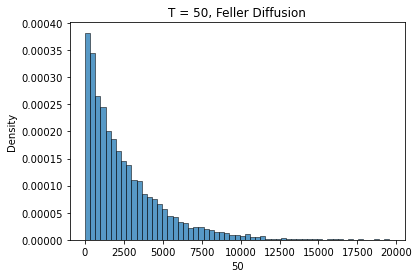

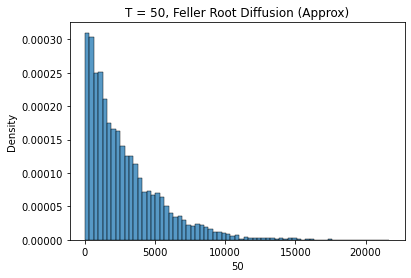

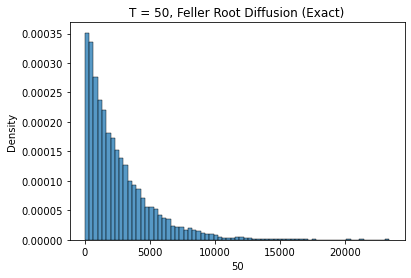

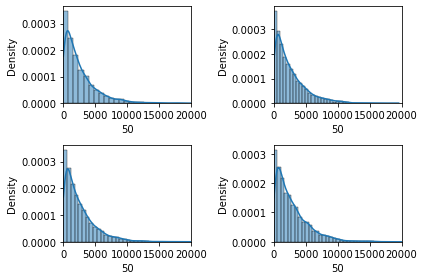

In [14]:
check_times_cols =[str(int(time[ct])) for ct in check_times_idxs]
check_cases_df = pd.DataFrame(check_cases, columns = [str(int(time[ct])) for ct in check_times_idxs])
check_cases_df.replace(0, np.nan, inplace=True)



check_cases_feller_df = pd.DataFrame(check_cases_feller.copy(), columns = [str(int(time[ct])) for ct in check_times_idxs_feller])
check_cases_feller_df.replace(0, np.nan, inplace=True)
plt.figure(20)
sns.histplot(check_cases_feller_df[check_times_cols[-1]].dropna(), stat = 'density')
plt.title("T = 50, Feller Diffusion" )

check_cases_feller_sqrt_df = pd.DataFrame(check_cases_feller_sqrt.copy(), columns = [str(int(time[ct])) for ct in check_times_idxs_feller])
check_cases_feller_sqrt_df.replace(0, np.nan, inplace=True)
plt.figure(21)
sns.histplot(check_cases_feller_sqrt_df[check_times_cols[-1]], stat = 'density')
plt.title("T = 50, Feller Root Diffusion (Approx)" )


ccfs_real_df = pd.DataFrame(ccfs_real.copy(), columns = [str(int(time[ct])) for ct in check_times_idxs_feller])
ccfs_real_df.replace(0, np.nan, inplace=True)


plt.figure(22)
sns.histplot(ccfs_real_df[check_times_cols[-1]], stat = 'density')
plt.title("T = 50, Feller Root Diffusion (Exact)")


fig, ax = plt.subplots(2, 2)
sns.histplot(check_cases_df[check_times_cols[-1]], stat = 'density', bins = 40, kde = True, ax = ax[0, 0])
sns.histplot(check_cases_feller_df[check_times_cols[-1]].dropna(), stat = 'density', bins = 40, kde = True, ax = ax[0, 1])
sns.histplot(ccfs_real_df[check_times_cols[-1]].dropna(), stat = 'density', bins = 40, kde = True, ax = ax[1, 0])
sns.histplot(check_cases_feller_sqrt_df[check_times_cols[-1]].dropna(), stat = 'density', bins = 40, kde = True, ax = ax[1, 1])


ax[0,0].set_xlim([0, 20000])
ax[0,1].set_xlim([0, 20000])
ax[1,0].set_xlim([0, 20000])
ax[1,1].set_xlim([0, 20000])




plt.tight_layout()


